In [318]:
import pinocchio as pin
import numpy as np
import time
import scipy
from example_robot_data import load

## visualise the robot
from pinocchio.visualize import MeshcatVisualizer

## visualise the polytope and the ellipsoid
import meshcat.geometry as g 

# import pycapacity 
import pycapacity as pycap

import meshcat

In [319]:
def getModelIds(q_shoulder, name):
    return [i for i, q in enumerate(q_shoulder) if name == q[3].split("_")[0]]

def getJointNames(robot):
    names = []
    for j in robot.model.frames[1:]:
        if robot.index(j.name) <= robot.nq:
            names.append(j.name)
    return names

def computeCollisions(robot, geom_model, q, verbose = True):
    geom_data = geom_model.createData()
    has_collision = pin.computeCollisions(robot.model, robot.data, geom_model, geom_data, q, not verbose)
    if verbose:
        print("Has collision {}".format(has_collision))
        i = 0
        for k in range(len(geom_model.collisionPairs)): 
          cr = geom_data.collisionResults[k]
          cp = geom_model.collisionPairs[k]
          if cr.isCollision():
              i = i+1
              print("collision pair:",cp.first,",",cp.second,"- collision:","Yes" if cr.isCollision() else "No")
        print(i)
    return has_collision

def jacobian(robot, q, tip = None, keep= None):
        
    if tip is None:
        tip = robot.model.frames[-1].name
    joint_id = model.getFrameId(tip)
    # joint_id = robot.model.getFrameId("r_wrist_ball_link")
    # joint_id =  model.getFrameId(robot.model.frames[-1].name)
    J = pin.computeFrameJacobian(robot.model,
                                       robot.data,
                                       q,
                                       joint_id,
                                       reference_frame=pin.LOCAL_WORLD_ALIGNED)[:3,:]
    
    if keep is None:
        u,s,v = np.linalg.svd(J)
    else:
        u,s,v = np.linalg.svd(J[:,keep])
    # print(J)
    return J, s

def dk(robot, q, tip = None):
    if tip is None:
        tip = robot.model.frames[-1].name
    # joint_id =  robot.model.getFrameId(robot.model.frames[-1].name)
    joint_id = robot.model.getFrameId(tip)
    pin.framesForwardKinematics(robot.model, robot.data, q)
    return robot.data.oMf[robot.model.getFrameId(tip)].translation.copy(), robot.data.oMf[robot.model.getFrameId(tip)].rotation

In [320]:
# use reachy's right arm with only 4 joints for now as they are the contribute 
# to its force capacity the most
# urdf_path = "reachy_v3_fix.urdf"
urdf_path = "reachy_v3_fix_shoulder.urdf"
# urdf_path = 'reachy_v3_simple.urdf'
# urdf_path = 'reachy.urdf'
robot = pin.RobotWrapper.BuildFromURDF(urdf_path)
model, data = robot.model, robot.data
# lock the other joints
tolock = [
   "l_shoulder_pitch",
   "l_shoulder_roll",
   "l_elbow_yaw",
   "l_elbow_pitch",
   "l_wrist_roll",
   "l_wrist_pitch",
   "l_wrist_yaw",
   "l_hand_finger",
   "l_hand_finger_mimic",
   "l_hand_finger_proximal",
   "l_hand_finger_distal",
   "l_hand_finger_proximal_mimic",
   "l_hand_finger_distal_mimic",
   "neck_roll",
   "neck_pitch",
   "neck_yaw",
   # "r_shoulder_dummy_1",
   # "r_shoulder_dummy_2",
   # "r_shoulder_dummy_out",
   # "r_shoulder_pitch",
   # "r_shoulder_roll",
   # "r_elbow_yaw",
   # "r_elbow_pitch",
   # "r_wrist_roll",
   # "r_wrist_pitch",
   # "r_wrist_yaw",
   "r_hand_finger",
   "r_hand_finger_mimic",
   "r_hand_finger_proximal",
   "r_hand_finger_distal",
   "r_hand_finger_proximal_mimic",
   "r_hand_finger_distal_mimic",
]

# Get the ID of all existing joints
jointsToLockIDs = []
for jn in tolock:
    if model.existJointName(jn):
        jointsToLockIDs.append(model.getJointId(jn))
robot.model, robot.collision_model = pin.buildReducedModel(model, robot.collision_model, jointsToLockIDs, np.zeros(robot.nq))
model, data = robot.model, robot.data



In [4]:
for i, g in enumerate(robot.collision_model.geometryObjects):
    print(i,g.name)

0 base_link_0
1 back_bar_0
2 torso_0
3 l_elbow_arm_link_0
4 l_elbow_forearm_link_0
5 l_wrist_link_0
6 l_hand_palm_link_0
7 l_hand_proximal_link_0
8 l_hand_distal_link_0
9 l_hand_proximal_mimic_link_0
10 l_hand_distal_mimic_link_0
11 head_0
12 r_elbow_arm_link_0
13 r_elbow_forearm_link_0
14 r_wrist_link_0
15 r_hand_palm_link_0
16 r_hand_proximal_link_0
17 r_hand_distal_link_0
18 r_hand_proximal_mimic_link_0
19 r_hand_distal_mimic_link_0
20 left_bar_0
21 right_bar_0


In [321]:
viewer = meshcat.Visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [322]:
robot.data = robot.model.createData()

# get joint position ranges
q_max = robot.model.upperPositionLimit.T
q_min = robot.model.lowerPositionLimit.T
q_min[[2,3,5,6,7,8,9]] = np.array([-np.pi, -3.07, -np.pi, -2.22,-np.pi/4,-np.pi/4,-np.pi])[:robot.nq]
q_max[[2,3,5,6,7,8,9]] = np.array([np.pi, 0.54, np.pi, 0.02,np.pi/4,np.pi/4,np.pi])[:robot.nq]
# robot.model.upperPositionLimit = q_max
# robot.model.lowerPositionLimit = q_min
dq_max = 5*np.ones(robot.nq)
dq_min = -dq_max
# get max velocity
t_max = np.ones(robot.nq)*4 # amps
t_min = -t_max

# Use robot configuration.
q = robot.q0[:robot.nq]
# q = (q_min+q_max)/2

model = robot.model
data = robot.model.createData()
geom_model = robot.collision_model
for i in [0, 1, 2, 11, 20, 21]: # torso, head, 3x bars
    # geom_model.addCollisionPair(pin.CollisionPair(i,3)) # left upper arm
    # geom_model.addCollisionPair(pin.CollisionPair(i,4)) # left lower arm
    # geom_model.addCollisionPair(pin.CollisionPair(i,5)) # left wrist
    # geom_model.addCollisionPair(pin.CollisionPair(i,6)) # left palm
    geom_model.addCollisionPair(pin.CollisionPair(i,12)) # right upper arm
    geom_model.addCollisionPair(pin.CollisionPair(i,13)) #  right lower arm
    geom_model.addCollisionPair(pin.CollisionPair(i,14)) #right  wrist
    geom_model.addCollisionPair(pin.CollisionPair(i,15)) # left palm
geom_data = pin.GeometryData(geom_model)
robot.rebuildData()
    

viz = MeshcatVisualizer(robot.model, robot.collision_model, robot.collision_model)
# Start a new MeshCat server and client.
viz.initViewer(open=True, viewer = viewer)
# Load the robot in the viewer.
viz.loadViewerModel("reachy")
viz.display(q)
# small time window for loading the model 
# if meshcat does not visualise the robot properly, augment the time
# it can be removed in most cases
time.sleep(0.2) 
viz.display_collisions = True

In [482]:
from ipywidgets import interact, FloatSlider, Layout, Label

kwargs = {"\tq[{}]".format(i,name) : 
          FloatSlider(
              min = q_min[i], 
              max = q_max[i], 
              step = 0.01, 
              value = q[i],
          layout=Layout(width='300px'))
          for i,(q_1, name) in enumerate(zip(q, getJointNames(robot)))}
@interact(**kwargs)
def update(**kwargs):
    q = np.array([v  for v in kwargs.values()])
    viz.display(q)
    computeCollisions(robot, geom_model, q)

interactive(children=(FloatSlider(value=0.0, description='\tq[0]', layout=Layout(width='300px'), max=1.5707963…

# Experiments 4dof

In [ ]:

# q_min_r = np.array([-np.pi, -3.07, -np.pi, -2.22,-np.pi/4,-np.pi/4,-np.pi])[:robot.nq]
# q_max_r = np.array([np.pi, 0.37, np.pi, 0.02,np.pi/4,np.pi/4,np.pi])[:robot.nq]


# q_shoulder = [
#     [0,0, 0, "beta"],
#     [-10,-15, 0, "straight"], # 0 up, straigth
#     [-20,-15, 0, "up10"], # 10 up, straigth
#     [-30,-15, 0, "up20"], # 20 up, straigth
#     [-30,-5, 0, "up20front10"], # 20 up, 10 front
#     [-30,0, 0, "up20front15"], # 20 up, 15 front
#     [0,0, 0.01, "beta_bic1"],
#     [-10,-15, 0.01, "straight_bic1"], # 0 up, straigth, elbow 1cm
#     [-20,-15, 0.01, "up10_bic1"], # 10 up, straigth, elbow 1cm
#     [-30,-15, 0.01, "up20_bic1"], # 20 up, straigth, elbow 1cm
#     [-30,-5, 0.01, "up20front10_bic1"], # 20 up, 10 front, elbow 1cm
#     [-30,0, 0.01, "up20front15_bic1"], # 20 up, 15 front, elbow 1cm
#     [0,0, 0.03, "beta_bic3"],
#     [-10,-15, 0.03, "straight_bic3"], # 0 up, straigth, elbow 3cm
#     [-20,-15, 0.03, "up10_bic3"], # 10 up, straigth, elbow 3cm
#     [-30,-15, 0.03, "up20_bic3"], # 20 up, straigth, elbow 3cm
#     [-30,-5, 0.03, "up20front10_bic3"], # 20 up, 10 front, elbow 3cm
#     [-30,0, 0.03, "up20front15_bic3"], # 20 up, 15 front, elbow 1cm
#     [0,0, 0.05, "beta_bic5"],
#     [-10,-15, 0.05, "straight_bic5"], # 0 up, straigth, elbow 5cm
#     [-20,-15, 0.05, "up10_bic5"], # 10 up, straigth, elbow 5cm
#     [-30,-15, 0.05, "up20_bic5"], # 20 up, straigth, elbow 5cm
#     [-30,-5, 0.05, "up20front10_bic5"], # 20 up, 10 front, elbow 5cm
#     [-30,0, 0.05, "up20front15_bic5"], # 20 up, 15 front, elbow 1cm
# ]

# s_vals_all, pos_all, s_v_all, colls_all = [], [], [], []
# N = 20
# tim = time.time()
# for q_sh in q_shoulder1:
#     q_ud = np.deg2rad(q_sh[0]) # up donw
#     q_fb = np.deg2rad(q_sh[1]) # front-back
#     offset_elbow = q_sh[2]# offset elbow
#     print(f"shoulder {q_sh}, {time.time() -tim} sec")
#     s_vals, pos, colls = [], [], [] 
#     for i,a in enumerate(np.linspace(q_min_r[0],q_max_r[0],N)):
#         print("\r" + f"{i+1}/{N}", end="")
#         if offset_elbow != 0.0:
#             q_max_1 = q_max_r[1] + np.deg2rad(10) # extended shoulder pitch range
#         else:
#             q_max_1 = q_max_r[1]
#         for b in np.linspace(q_min_r[1],q_max_1,N):
#             for d in np.linspace(q_min_r[2],q_max_r[2],N):
#                 for e in np.linspace(q_min_r[3],q_max_r[3],N):
#                     q = np.array(np.hstack(([q_ud, q_fb],[a,b,offset_elbow,d,e],np.zeros(robot.nq - 4 - 3))))
#                     J, s = jacobian(robot, q, tip="r_wrist_ball_link",keep=[2,3,5,6])
#                     s_vals.append(s)
#                     t, r = dk(robot, q, tip="r_wrist_ball_link")
#                     pos.append(t)
#                     colls.append(computeCollisions(robot, geom_model, q, False))
#     s_vals = np.array(s_vals)
#     pos = np.array(pos)
#     s_v = np.prod(s_vals, axis=1)
#     colls = np.array(colls)
#     s_vals_all.append(s_vals)        
#     pos_all.append(pos)
#     print("\n")
#     s_v_all.append(s_v)
#     colls_all.append(colls)
# print("\ndone")
# s_max = np.max(s_v)

# Loading the previously generated data

In [451]:
# import pickle
# filename = "data/reachability_4dof_biceps_10.pckl"
# with open(filename, 'wb') as f:
#     pickle.dump([s_vals_all, pos_all, s_v_all, colls_all, q_shoulder], f)

In [452]:
import pickle
filename = "data/reachability_4dof_biceps_10.pckl"
with open(filename, 'rb') as f:
    s_vals_all, pos_all, s_v_all, colls_all, q_shoulder =  pickle.load(f)

In [453]:
betas = [q[3] for q in q_shoulder if "_bic" not in q[3]]
print("models available", betas)

models available ['beta', 'straight', 'up10', 'up20', 'up20front10', 'up20front15', 'back5']


In [455]:
q_shoulder

[[0, 0, 0, 'beta'],
 [-10, -15, 0, 'straight'],
 [-20, -15, 0, 'up10'],
 [-30, -15, 0, 'up20'],
 [-30, -5, 0, 'up20front10'],
 [0, 0, 0.01, 'beta_bic1'],
 [-10, -15, 0.01, 'straight_bic1'],
 [-20, -15, 0.01, 'up10_bic1'],
 [-30, -15, 0.01, 'up20_bic1'],
 [-30, -5, 0.01, 'up20front10_bic1'],
 [0, 0, 0.03, 'beta_bic3'],
 [-10, -15, 0.03, 'straight_bic3'],
 [-20, -15, 0.03, 'up10_bic3'],
 [-30, -15, 0.03, 'up20_bic3'],
 [-30, -5, 0.03, 'up20front10_bic3'],
 [0, 0, 0.05, 'beta_bic5'],
 [-10, -15, 0.05, 'straight_bic5'],
 [-20, -15, 0.05, 'up10_bic5'],
 [-30, -15, 0.05, 'up20_bic5'],
 [-30, -5, 0.05, 'up20front10_bic5'],
 [-30, 0, 0, 'up20front15'],
 [-30, 0, 0.01, 'up20front15_bic1'],
 [-30, 0, 0.03, 'up20front15_bic3'],
 [-30, 0, 0.05, 'up20front15_bic5'],
 [-10, -20, 0, 'back5'],
 [-10, -20, 0.01, 'back5_bic1'],
 [-10, -20, 0.03, 'back5_bic3'],
 [-10, -20, 0.05, 'back5_bic5']]

# Data visualisaiton in Mechcat

### Reacahble space

In [521]:
## visualise the polytope and the ellipsoid
import meshcat.geometry as g 

ind = getModelIds(q_shoulder, "beta")[0]
colls = colls_all[ind]
pos = pos_all[ind]
s_v = s_v_all[ind]

print(max(s_v))

s_max = max(s_v)
# s_max = 0.1
s_only_low = (1-colls).copy()
s_only_low = s_only_low[colls==False]
pos_only_low = pos.copy()
pos_only_low = pos_only_low[colls==False]
# Visualize the point cloud
viz.viewer["point_cloud_reachable"].set_object(g.PointCloud(position=pos_only_low.T, color=np.array([1*s_only_low/s_max, 1*s_only_low/s_max, np.zeros_like(s_only_low)]),size=0.007))
## visualise the polytope and the ellipsoid
import meshcat.geometry as g 

print(max(s_v))
ind = np.array([True]*len(pos_only_low[:,0]))
ind *= (pos_only_low[:,0]>0) 
ind *= (pos_only_low[:,1] > -0.5) 
ind *= (pos_only_low[:,2]> 0.65)* (pos_only_low[:,2]< 1.1)

s_max = max(s_v)
# s_max = 0.1
s_only_low = s_only_low[ind]
pos_only_low = pos_only_low[ind,:]
# Visualize the point cloud
viz.viewer["point_cloud_reachable"].set_object(g.PointCloud(position=pos_only_low.T, color=np.array([1*s_only_low/s_max, 1*s_only_low/s_max, np.zeros_like(s_only_low)]),size=0.007))
from reachable_space_utils  import *
verts, faces = alpha_shape_with_cgal(pos_only_low, alpha=0.1)
vert = faces.reshape(-1,3)
faces = np.arange(len(vert)).reshape(-1,3)
poly = g.TriangularMeshGeometry(vertices=vert, faces=faces)
viz.viewer['poly'].set_object(poly, g.MeshBasicMaterial(color=0x000000, wireframe=False, linewidth=2, opacity=0.2))

0.039315834919735004
0.039315834919735004


In [510]:
## visualise the polytope and the ellipsoid
import meshcat.geometry as g 

ind = getModelIds(q_shoulder, "up20")[0]
colls = colls_all[ind]
pos = pos_all[ind]
s_v = s_v_all[ind]

print(max(s_v))

s_max = max(s_v)
# s_max = 0.1
s_only_low = (1-colls).copy()
s_only_low = s_only_low[colls==False]
pos_only_low = pos.copy()
pos_only_low = pos_only_low[colls==False]
# Visualize the point cloud
# viz.viewer["point_cloud"].set_object(g.PointCloud(position=pos_only_low.T, color=np.array([1*s_only_low/s_max, 1*s_only_low/s_max, np.zeros_like(s_only_low)]),size=0.007))
## visualise the polytope and the ellipsoid
import meshcat.geometry as g 

ind = np.array([True]*len(pos_only_low[:,0]))
ind *= (pos_only_low[:,0]>0) 
ind *= (pos_only_low[:,1] > -0.5) 
ind *= (pos_only_low[:,2]> 0.65)* (pos_only_low[:,2]< 1.15)

s_max = max(s_v)
# s_max = 0.1
s_only_low = s_only_low[ind]
pos_only_low = pos_only_low[ind,:]
# Visualize the point cloud
viz.viewer["point_cloud_reachable"].set_object(g.PointCloud(position=pos_only_low.T, color=np.array([1*s_only_low/s_max, 1*s_only_low/s_max, np.zeros_like(s_only_low)]),size=0.007))
# viz.viewer["point_cloud"].set_object(g.PointCloud(position=pos_only_low.T, color=np.array([1*s_only_low/s_max, 1*s_only_low/s_max, np.zeros_like(s_only_low)]),size=0.007))
from reachable_space_utils  import *
verts, faces = alpha_shape_with_cgal(pos_only_low, alpha=0.1)
vert = faces.reshape(-1,3)
faces = np.arange(len(vert)).reshape(-1,3)
poly = g.TriangularMeshGeometry(vertices=vert, faces=faces)
viz.viewer['poly_comp'].set_object(poly, g.MeshBasicMaterial(color=0x000000, wireframe=True, linewidth=2, opacity=0.2))

0.03931583491973501


In [509]:
pos_only_low_l = np.array([pos_only_low[:,0],-pos_only_low[:,1],pos_only_low[:,2]])
from reachable_space_utils  import *
verts, faces = alpha_shape_with_cgal(pos_only_low_l.T, alpha=0.1)
vert = faces.reshape(-1,3)
faces = np.arange(len(vert)).reshape(-1,3)
poly = g.TriangularMeshGeometry(vertices=vert, faces=faces)
# viz.viewer['poly_l'].set_object(poly, g.MeshBasicMaterial(color=0x000000, wireframe=False, linewidth=2, opacity=0))
# viz.viewer["point_cloud_l"].set_object(g.PointCloud(position=np.zeros(3).T, color = np.array([0,0,1]), size=0.007))
viz.viewer["point_cloud_reachable_l"].set_object(g.PointCloud(position=pos_only_low_l, color=np.array([0.05*s_only_low/s_max,np.zeros_like(s_only_low), 0.05*s_only_low/s_max, ]),size=0.007))
viz.viewer['poly_l'].set_object(poly, g.MeshBasicMaterial(color=0xFF0000, wireframe=True, linewidth=2, opacity=0.2))

In [415]:
q = np.zeros(robot.nq)

### Manipulability

In [536]:
## visualise the polytope and the ellipsoid
import meshcat.geometry as g 

ind = getModelIds(q_shoulder, "up20")[0]
colls = colls_all[ind]
pos = pos_all[ind]
s_v = s_v_all[ind]


# print(max(s_v))

s_max = np.max(s_v_all)
print(max(s_v),s_max)

s_only_low = s_v.copy()
# keep the non-collisions only
pos_only_low = pos.copy()
s_only_low = s_only_low[colls==False]
pos_only_low = pos_only_low[colls==False]
# keep low manipulability only
pos_only_low = pos_only_low[s_only_low < 0.01]
s_only_low = s_only_low[s_only_low < 0.01]
# keep the ones not too far
dist = np.linalg.norm(pos_only_low - dk(robot, q, tip="r_shoulder_ball_link")[0], axis=1)
pos_only_low = pos_only_low[dist < 0.53]
s_only_low = s_only_low[dist < 0.53]

# Visualize the point cloud
viz.viewer["point_cloud_manip"].set_object(g.PointCloud(position=pos_only_low.T, color=np.array([1-s_only_low/s_max, s_only_low/s_max, np.zeros_like(s_only_low)]),size=0.007))
## visualise the polytope and the ellipsoid
import meshcat.geometry as g 

print(max(s_v))
ind = np.array([True]*len(pos_only_low[:,0]))
ind *= (pos_only_low[:,0]>0) 
ind *= (pos_only_low[:,1] > -0.5) 
ind *= (pos_only_low[:,2]> 0.65)* (pos_only_low[:,2]< 1.1)

# s_max = 0.1
s_only_low = s_only_low[ind]
pos_only_low = pos_only_low[ind,:]
# Visualize the point cloud
# viz.viewer["point_cloud_manip"].set_object(g.PointCloud(position=pos_only_low.T, color=np.array([1-s_only_low/s_max, s_only_low/s_max, np.zeros_like(s_only_low)]),size=0.007))

0.03931583491973501 0.04052400633644883
0.03931583491973501


# Statistical analysis of the data 

In [468]:
import numpy as np
from scipy.spatial import ConvexHull


beta = [q[-1] for q in q_shoulder]
betas = [q[3] for q in q_shoulder if "_bic" not in q[3]]
biceps_offset = [(q[-2]*100) for q in q_shoulder]

# Collect data for the table
table_data = []
row_data = []
vols=[]
for j, (p,c) in enumerate(zip(pos_all,colls_all)):
    pos_only_low = p.copy()
    p = pos_only_low[c!=True]
    ind = (p[:,0]>0) \
     * (p[:,1] > -0.5) \
     * (p[:,2]> 0.65)* (p[:,2]< 1.15)
    p = p[ind,:]
    a = ConvexHull(p).volume
    vols.append(a)
    row_data.append([a, [min(p[:,0]),max(p[:,0])], [min(p[:,1]),max(p[:,1])], [min(p[:,2]),max(p[:,2])]])
table_data.append(row_data)

# Export data to Markdown table
markdown_table = "| Beta | Biceps Offset [cm] |Reachable Volume [dm^3] | X range [m] | Y range [m] | Z range [m] |\n"
markdown_table += "|----------| ----| -----------|-------|-------|-------|\n"

for i, row_data in enumerate(table_data):
    for j, data in enumerate(row_data):
        markdown_table += f"| {beta[j]}"
        markdown_table += f"| {biceps_offset[j]}"
        markdown_table += f" | {data[0]*1e3:0.2f}"
        for d in data[1:]:
            markdown_table += f" | [{d[0]:0.3f},{d[1]:0.3f}]"
        markdown_table+= f"|\n"

print(markdown_table)

| Beta | Biceps Offset [cm] |Reachable Volume [dm^3] | X range [m] | Y range [m] | Z range [m] |
|----------| ----| -----------|-------|-------|-------|
| beta| 0 | 152.60 | [0.000,0.515] | [-0.500,0.247] | [0.650,1.150]|
| straight| 0 | 142.94 | [0.000,0.514] | [-0.500,0.180] | [0.650,1.150]|
| up10| 0 | 141.74 | [0.000,0.515] | [-0.500,0.190] | [0.650,1.150]|
| up20| 0 | 139.35 | [0.000,0.515] | [-0.500,0.200] | [0.650,1.150]|
| up20front10| 0 | 148.43 | [0.000,0.515] | [-0.500,0.240] | [0.650,1.150]|
| beta_bic1| 1.0 | 153.91 | [0.000,0.515] | [-0.500,0.244] | [0.650,1.150]|
| straight_bic1| 1.0 | 151.00 | [0.000,0.514] | [-0.500,0.216] | [0.650,1.150]|
| up10_bic1| 1.0 | 148.97 | [0.000,0.514] | [-0.500,0.224] | [0.650,1.150]|
| up20_bic1| 1.0 | 146.42 | [0.000,0.514] | [-0.500,0.232] | [0.650,1.150]|
| up20front10_bic1| 1.0 | 151.48 | [0.000,0.514] | [-0.500,0.243] | [0.650,1.150]|
| beta_bic3| 3.0 | 157.86 | [0.000,0.515] | [-0.500,0.270] | [0.650,1.150]|
| straight_bic3| 3.0 | 1

0.020502529236682096 0.039315834919734956 0.0006080729296581756
0.02170060834329468 0.03931583491973496 0.0007507292253824988
0.021999033861599505 0.039315834919734956 0.0007507292253825025
0.022186402420966582 0.039315834919734984 0.0007507292253824929
0.02169018038865357 0.03931583491973498 0.0006564772032041736
0.020582529256470194 0.039424719177251974 6.194297810779048e-05
0.021759972577917522 0.03942471917725196 7.764211698626665e-05
0.022019696611954423 0.03942471917725195 7.764211698627365e-05
0.022245798669708487 0.03942471917725198 7.764211698631115e-05
0.021795799517128248 0.03942471917725197 7.28732104430992e-05
0.020672073592361243 0.03974063693909276 0.00010359669230403409
0.021901888925776932 0.039740636939092744 0.00013152848334034234
0.022260150144036733 0.03974063693909275 0.00012498534194590186
0.02257224707839611 0.03974063693909278 0.00013152848334035085
0.02207524703621844 0.03974063693909275 0.00012006493652917455
0.020600320648104728 0.04052400633644879 0.0003348

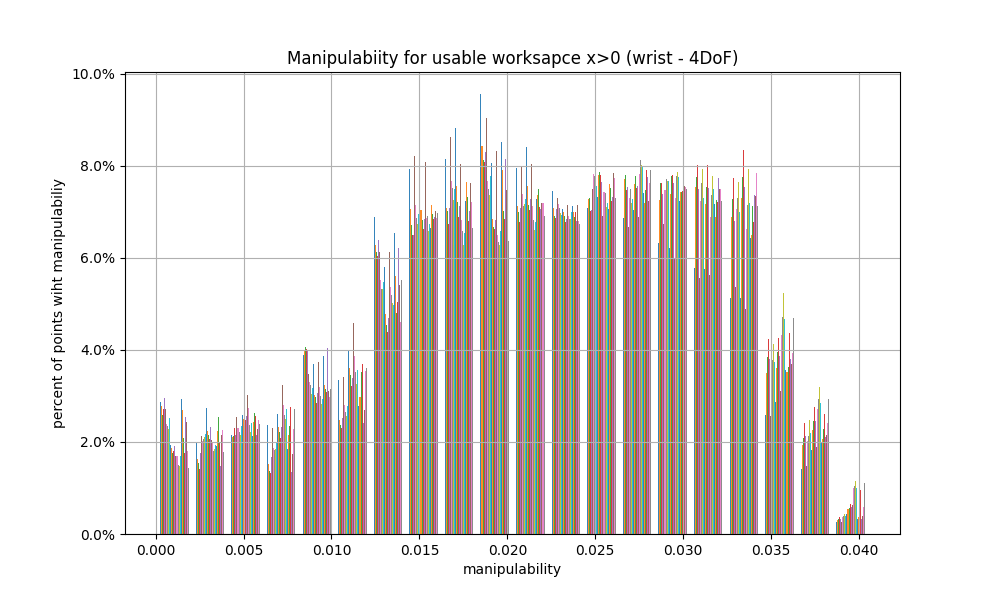

In [469]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.figure(figsize=(10,6))
plt.grid()
s_hist, wigths_hist= [],[]

for i,s in enumerate(s_v_all):
    pos_only_low = pos_all[i].copy()
    p = pos_only_low[colls_all[i]!=True,:]
    ind = (p[:,0]>0) \
     * (p[:,1] > -0.5) \
     * (p[:,2]> 0.65)* (p[:,2]< 1.15)
    p = p[ind,:]
    s = s[colls_all[i]!=True]
    s = s[ind]
    s_hist.append(s)
    wigths_hist.append(np.ones(len(s_hist[-1]))/len(s_hist[-1]))
    print(np.mean(s),np.max(s), np.min(s))
    # plt.hist(s_hist[-1],weights=wigths_hist[-1], bins=50, alpha=0.4)
    # pos = pos[pos[:,0]>0]
plt.hist(s_hist,weights=wigths_hist, bins=20,alpha=0.9)

manipulability = [np.mean(s) for s in s_hist]

plt.title("Manipulabiity for usable worksapce x>0 (wrist - 4DoF)")
plt.xlabel("manipulability")
plt.ylabel("percent of points wiht manipulabiliy")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()
# plt.legend(beta)

In [470]:
import numpy as np
from scipy.spatial import ConvexHull



# Export data to Markdown table
markdown_table = "| Beta | Reachable Volume [dm^3] | Change [%] | manipulabilty | Change [%] |\n"
markdown_table += "|----------| -----------|-------|-------|-------|\n"

for i, (v, m) in enumerate(zip(vols, manipulability)):
    markdown_table += f"| {beta[i]}"
    markdown_table += f" | {v*1e3:0.4f}"
    markdown_table += f" | {(v/vols[0]-1)*100:+0.2f}%"
    markdown_table += f" | {m:0.5f}"
    markdown_table += f" | {(m/manipulability[0]-1)*100:+0.2f}%"
    markdown_table+= f"|\n"

print(markdown_table)

| Beta | Reachable Volume [dm^3] | Change [%] | manipulabilty | Change [%] |
|----------| -----------|-------|-------|-------|
| beta | 152.5970 | +0.00% | 0.02050 | +0.00%|
| straight | 142.9355 | -6.33% | 0.02170 | +5.84%|
| up10 | 141.7353 | -7.12% | 0.02200 | +7.30%|
| up20 | 139.3496 | -8.68% | 0.02219 | +8.21%|
| up20front10 | 148.4333 | -2.73% | 0.02169 | +5.79%|
| beta_bic1 | 153.9112 | +0.86% | 0.02058 | +0.39%|
| straight_bic1 | 150.9991 | -1.05% | 0.02176 | +6.13%|
| up10_bic1 | 148.9680 | -2.38% | 0.02202 | +7.40%|
| up20_bic1 | 146.4209 | -4.05% | 0.02225 | +8.50%|
| up20front10_bic1 | 151.4768 | -0.73% | 0.02180 | +6.31%|
| beta_bic3 | 157.8611 | +3.45% | 0.02067 | +0.83%|
| straight_bic3 | 148.4148 | -2.74% | 0.02190 | +6.83%|
| up10_bic3 | 147.7832 | -3.15% | 0.02226 | +8.57%|
| up20_bic3 | 144.6292 | -5.22% | 0.02257 | +10.09%|
| up20front10_bic3 | 152.0767 | -0.34% | 0.02208 | +7.67%|
| beta_bic5 | 157.4370 | +3.17% | 0.02060 | +0.48%|
| straight_bic5 | 145.7966 | -4.

[0, 5, 10, 15] beta
[1, 6, 11, 16] straight
[2, 7, 12, 17] up10
[3, 8, 13, 18] up20
[4, 9, 14, 19] up20front10
[20, 21, 22, 23] up20front15
[24, 25, 26, 27] back5


(-0.5, 12.076046066818746)

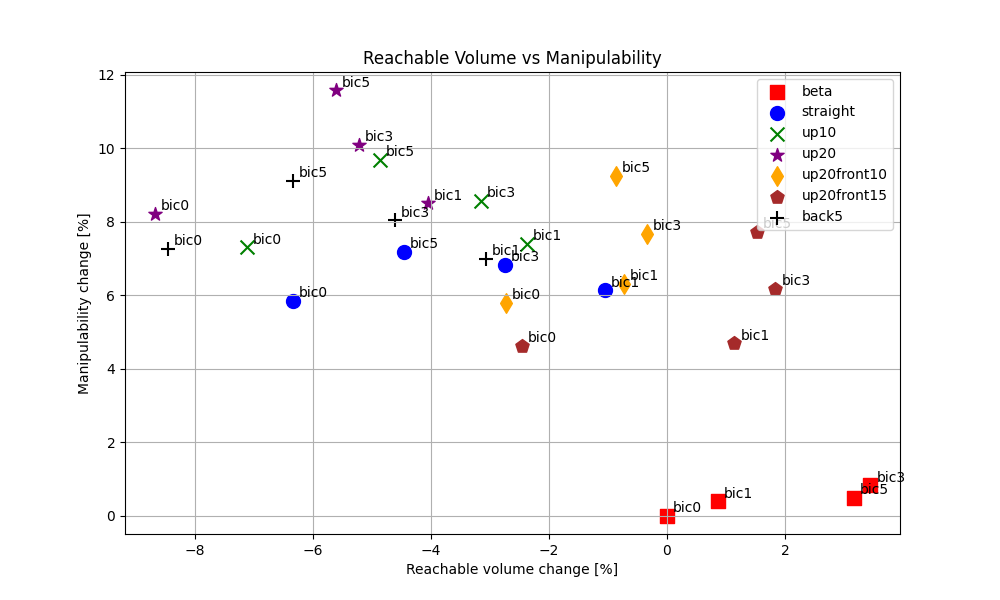

In [471]:

# Create scatter plot
plt.figure(figsize=(10, 6))
v_change = (np.array(vols)/vols[0]-1)*100
manip_chage = (np.array(manipulability)/manipulability[0]-1)*100
markers = ["s", "o", "x", "*", "d", "p","+"]
colors = ["red","blue","green","purple","orange","brown","black"]
         
for k,b in enumerate(betas):
    ids = getModelIds(q_shoulder,b)
    print(ids,b)
    scatter = plt.scatter(v_change[ids],  manip_chage[ids], c=colors[k], s=100, marker=markers[k], label=b)

# Annotate each point with the beta name
for i, label in enumerate(beta):
    plt.annotate(f"bic{int(biceps_offset[i]):d}", (v_change[i]+0.1, manip_chage[i]+0.1), fontsize=10, ha='left')

# Add labels and title
plt.xlabel('Reachable volume change [%]')
plt.ylabel('Manipulability change [%]')
plt.title('Reachable Volume vs Manipulability')

plt.grid(True)
plt.legend()
plt.xlim([np.min(v_change)-0.5, np.max(v_change)+0.5])
plt.ylim([np.min(manip_chage)-0.5, np.max(manip_chage)+0.5])

In [63]:
list(enumerate(betas))

[(0, 'beta'),
 (1, 'straight'),
 (2, 'up10'),
 (3, 'up20'),
 (4, 'up20front10'),
 (5, 'up20front15')]